In [1]:
%matplotlib inline
import time
import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader
import torchvision
from PIL import Image

import sys
sys.path.append('../code/')
import d2lzh_pytorch as d2l
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

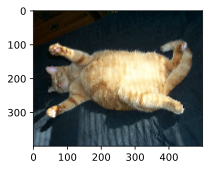

In [2]:
d2l.set_figsize()
img=Image.open('../img/cat1.jpg')
d2l.plt.imshow(img)

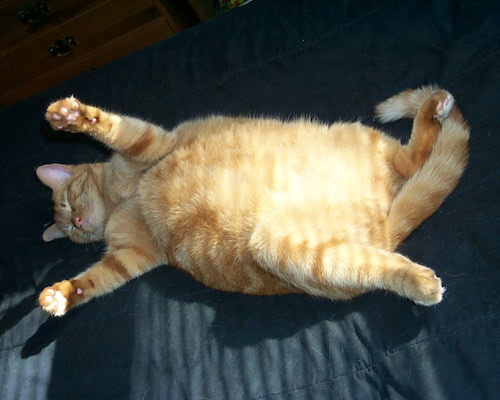

In [3]:
img

In [8]:
def show_images(imgs,num_rows,num_cols,scale=2):
    figsize=(num_cols*scale,num_rows*scale)
    _,axes=d2l.plt.subplots(num_rows,num_cols,figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i*num_cols+j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

In [14]:
def apply(img,aug,num_rows=2,num_cols=4,scale=1.5):
    Y=[aug(img) for _ in range(num_rows*num_cols)]
    show_images(Y,num_rows,num_cols,scale)

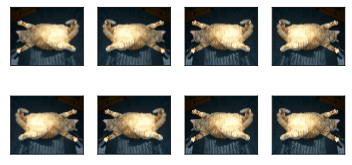

In [15]:
apply(img,torchvision.transforms.RandomHorizontalFlip())

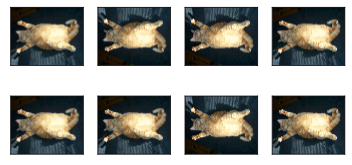

In [16]:
apply(img,torchvision.transforms.RandomVerticalFlip())

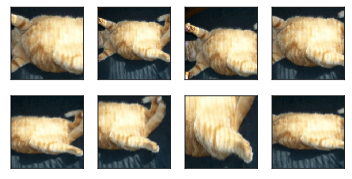

In [18]:
shape_aug=torchvision.transforms.RandomResizedCrop(200,scale=(0.1,1),ratio=(0.5,2))
apply(img,shape_aug)

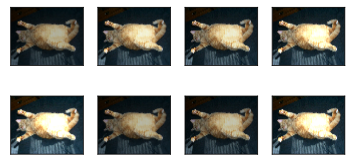

In [19]:
apply(img,torchvision.transforms.ColorJitter(brightness=0.5))

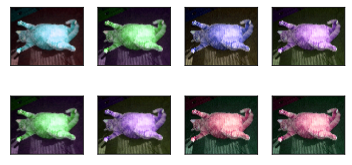

In [20]:
apply(img,torchvision.transforms.ColorJitter(hue=0.5))

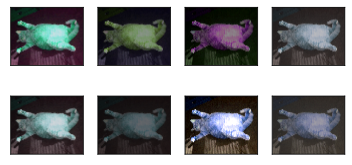

In [21]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img,color_aug)

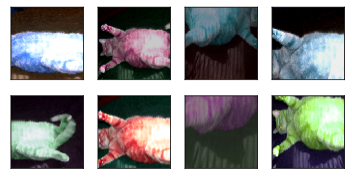

In [22]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

In [25]:
all_imges=torchvision.datasets.CIFAR10(train=True,root='/workspace/mycode/Dive-into-DL-PyTorch/data/',download=True)

Files already downloaded and verified


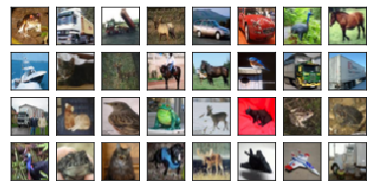

In [30]:
show_images([all_imges[i][0] for i in range(32)],4,8,scale=0.8);

In [31]:
flip_aug=torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(),
                                        torchvision.transforms.ToTensor()])

no_aug=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [33]:
num_workers =0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_trian,augs,batch_size,root='/workspace/mycode/Dive-into-DL-PyTorch/data/'):
    dataset=torchvision.datasets.CIFAR10(root=root,train=is_trian,transform=augs,download=True)
    return DataLoader(dataset,batch_size=batch_size,shuffle=is_trian,num_workers=num_workers)

In [37]:
def train(train_iter,test_iter,net,loss,optimizer,device,num_epochs):
    net=net.to(device)
    print('training on',device)
    batch_count=0
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n,start=0.0,0.0,0,time.time()
        for X,y in train_iter:
            net=net.to(device)
            X=X.to(device)
            y=y.to(device)
            y_hat=net(X)
            l=loss(y_hat,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.cpu().item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().cpu().item()
            n+=y.shape[0]
            batch_count+=1
        test_acc=d2l.evaluate_accuracy(test_iter,net)
        print('epoch %d, loss %.4f, train acc %.3f, test_acc %.3f, time %.1f sec' 
              % (epoch+1,train_l_sum/batch_count,train_acc_sum/n,test_acc,time.time()-start))

In [38]:
def train_with_data_aug(train_augs,test_augs,lr=0.001):
    batch_size,net=256,d2l.resnet18(10)
    optimizer=torch.optim.Adam(net.parameters(),lr=lr)
    loss=torch.nn.CrossEntropyLoss()
    train_iter=load_cifar10(True,train_augs,batch_size)
    test_iter=load_cifar10(False,test_augs,batch_size)
    train(train_iter,test_iter,net,loss,optimizer,device,num_epochs=10)

In [39]:
train_with_data_aug(flip_aug,no_aug)

Files already downloaded and verified
Files already downloaded and verified
training on cuda
epoch 1, loss 1.4071, train acc 0.494, test_acc 0.487, time 78.1 sec
epoch 2, loss 0.5098, train acc 0.639, test_acc 0.543, time 78.3 sec
epoch 3, loss 0.2879, train acc 0.696, test_acc 0.615, time 78.3 sec
epoch 4, loss 0.1899, train acc 0.732, test_acc 0.668, time 78.3 sec
epoch 5, loss 0.1355, train acc 0.762, test_acc 0.584, time 78.3 sec
epoch 6, loss 0.1017, train acc 0.787, test_acc 0.675, time 78.4 sec
epoch 7, loss 0.0795, train acc 0.806, test_acc 0.650, time 78.5 sec
epoch 8, loss 0.0631, train acc 0.826, test_acc 0.745, time 78.5 sec
epoch 9, loss 0.0522, train acc 0.838, test_acc 0.760, time 78.5 sec
epoch 10, loss 0.0428, train acc 0.851, test_acc 0.715, time 78.6 sec
